# <center>R3.08 - Probabilités <br>TP2 - Premiers hasards <center>


_Benjamin Dufée, Thibault Godin_

_IUT de Vannes, BUT Informatique_

    
L'objectif de ce TP est double : d'une part, étudier la répartition des nombres premiers et leurs propriétés probabilistes dans un intervalle donné [m, M] ; d'autre part, mettre en œuvre des algorithmes probabilistes de test de primalité, et en analyser les limites.


---

## 0 Préliminaires et outils

### Rappel théorique
Le crible d'Ératosthène permet de lister efficacement les nombres premiers jusqu’à une borne donnée. Il sert de base pour compter les premiers dans un intervalle.



In [1]:
input_bytes = b"\x01"
output_numbers = list(input_bytes)
output_numbers

[1]

In [2]:
import math, random
import numpy as np
import matplotlib.pyplot as plt


import sympy as sp

In [3]:
#fonction pré-définie
def isprime(n) : 
    return sp.isprime(n)


#bytearray -> plus leger si grands nombre 
#(on a juste besoin de 0 "pas premier" 1 "premier", le nombre correspond à l'indice)
def list_primes(n):
    if n < 2:
        return []
    sieve = bytearray(b"\x01") * (n+1)
    sieve[0:2] = b"\x00\x00"
    for p in range(2, int(n**0.5)+1):
        if sieve[p]:
            sieve[p*p:n+1:p] = b"\x00" * (((n - p*p)//p) + 1)
    return [i for i, v in enumerate(sieve) if v]

def count_primes_interval(m, M):
    return sum(1 for p in list_primes(M) if m <= p <= M)

list_primes(50)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]

---

## 1 Nombre de nombres premiers dans [m, M]

### Un peu de théorie

Dans tout le TP, on notera $\pi(N)$ le nombre de nombres premiers inférieurs à $N$


Le théorème des nombres premiers affirme que $$\pi(N) \sim \frac{N}{\ln(N)}$$

Dans un intervalle $[m, M]$, on approxime  $\pi([m,M]) \sim \frac{M}{\ln(M)} - \frac{m}{\ln(m)}$.

### Expérience

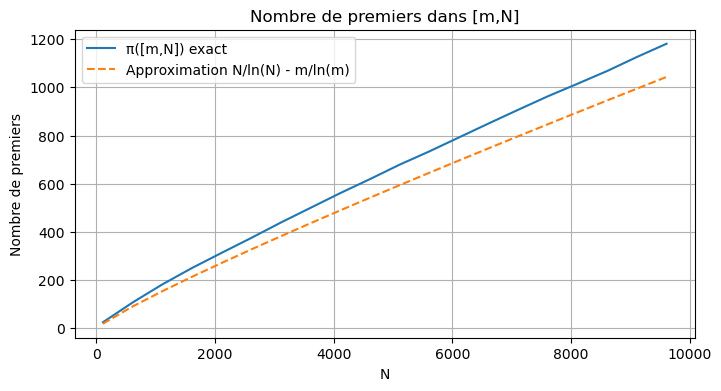

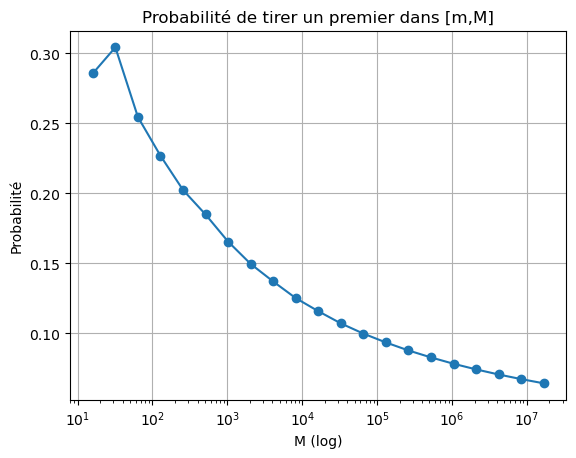

In [4]:
m, M = 10, 10000
steps = list(range(m+100, M+1, 500))
counts = [count_primes_interval(m, N) for N in steps]
approxs = [(N)/math.log(N) - (m+1)/math.log(m+1)  for N in steps]

plt.figure(figsize=(8,4))
plt.plot(steps, counts, label='π([m,N]) exact')
plt.plot(steps, approxs, label='Approximation N/ln(N) - m/ln(m)', linestyle='--')
plt.xlabel('N'); plt.ylabel('Nombre de premiers')
plt.legend(); plt.grid(True)
plt.title('Nombre de premiers dans [m,N]')
plt.show()



def prob_prime_interval(m, M):
    if M < 2 or M <= m: return 0.0
    return count_primes_interval(m,M) / (M-m+1)

m, M = 10, 100000
steps = [2**k for k in range(4,25)]
probs = [prob_prime_interval(m,N) for N in steps]

plt.plot(steps, probs, marker='o')
plt.xscale('log'); plt.grid(True)
plt.xlabel('M (log)'); plt.ylabel('Probabilité')
plt.title('Probabilité de tirer un premier dans [m,M]')
plt.show()

---

## 2 Nombre moyen d’essais pour trouver un premier

Dans de nombreuses applications, et en particulier en cryptographie, on a besoin de (grands) nombres premiers.

Un méthode naive consiste à tirer un nombre au hasard en espérant qu'il soit premier.

Voyons combien d'essai cela prend en moyenne

>__Question 1 :__ 
> En utilisant la fonctionn `isprime(n)` définie plus haut et la fonction `rng.randint` de la bibliothèque <tt>random</tt>, écrire une fonction qui calcule le nombre moyen d'essais (selon la loi uniforme sur $\{m,m+1,... M\}$) avant de tirer un premier. On fera la moyenne sur <tt>trials</tt> essais.
>Tracer en fonction de $M$ avec $m = 2$


In [10]:
import sympy.core.random as rng

def avg_trials_until_prime(m, M, trials=2000):
    cpt=0
    for i in range(trials) : 
        n = rng.randint(m, M)
        essai=1
        while not(isprime(n)) : 
            essai = essai + 1
            n = rng.randint(m, M)
        cpt = cpt+essai
    return cpt/trials

for N in [100, 1000, 5000, 10000]:
    print(N, avg_trials_until_prime(m,N, trials=2000))

100 4.416
1000 5.9325
5000 7.2945
10000 8.025


In [7]:
import sympy.core.random as rng

def avg_trials_until_prime(m, M, trials=2000):
    cpt = 0
    for i in range(trials) : 
        n = rng.randint(m, M)
        essai = 1
        while not(isprime(n)) : 
            n = rng.randint(m, M)
            essai = essai + 1
        cpt+=essai
    return cpt/trials

for N in [100, 1000, 5000, 10000]:
    print(N, avg_trials_until_prime(m,N, trials=2000))

100 4.263
1000 6.1335
5000 7.572
10000 8.024


---


## 3 Premiers probables : méthode naïve

### Explication

Pour savoir si un nombre $n$ est (possiblement) premier, on prend un nombre témoin $a \in [2,\sqrt{n}]$ au hasard et on vérifie si $a |n $. Si oui alors $n$ est peut-être premier, si non alors on est sûr que $n$ n'est pas premier.

Un nombre $a$ qui affirme que le nombre $n$ est peut-être premier alors qu'il ne l'est pas est appelé un **menteur**

On augmente notre confiance en ajoutant des témoins

>__Question 2 :__ 
> Implémentez une fonction `test_naif(n)` qui applique ce critère pour un témoin, et une fonction `is_probable_prime_naif(n,k)` qui teste $k$ témoins.


In [40]:
def test_naif(n,verbose=False) : 
    a = rng.randint(2, int(math.sqrt(n)))
    if (n%a == 0) : 
        return False
    else : 
        return True
    
def is_probable_prime_naif(n, k=5,verbose=False):
    for i in range(k) : 
        a = rng.randint(2, int(math.sqrt(n)))
        if (n%a != 0) :
            return True 
    return False    



print(test_naif(6,True))
is_probable_prime_naif(240,2, False)




False


True


>__Question 3 :__ 
> Donnez des exemples de faux positifs, et tracez une visialisation l'évolution de la fiabilité du test en fonction de $k$

In [ ]:
def faux_pos_naif(k=5, essais=10000, borne=10000):

    erreurs = 0  # nombre de faux positifs détectés
    total = 0    # nombre total de nombres testés

    for _ in range(essais):
        n = random.randint(4, borne)  # tire un nombre aléatoire ≥ 4
        if not isprime(n):  # on ne teste QUE des nombres composés
            total += 1
            if is_probable_prime_naif(n, k):  # le test naïf croit qu'il est premier
                erreurs += 1  # -> faux positif

    if total == 0:
        return 0.0
    return erreurs / total

faux_pos_naif(100000)

(9468491495, 55)

---

## 4 Critère de Fermat

### Explication

>**Théorème (petit théorème de Fermat) :**<br>
>
>Si $p$ est un nombre premier et $a$ un entier alors 
>$$ a^p \equiv a [p] $$


En ce basant sur ce théorème on peut déduire un test partiel de primalité : 
pour savoir si un nombre $n$ est (possiblement) premier, on prend un nombre témoin $a$ au hasard et on vérifie si $a^n \equiv a [n]$. Si oui alors $n$ est peut-être premier, si non alors on est sûr que $n$ n'est pas premier.

On augmente notre confiance en ajoutant des témoins

>__Question 4 :__ 
> Implémentez une fonction `test_Fermat(n)` qui applique ce critère pour un témoin, et une fonction `is_probable_prime_Fermat(n,k)` qui teste $k$ témoins.


In [8]:
def test_Fermat_det(n,a,verbose=False) : 
    return False
    
def test_Fermat(n,verbose=False):
    
    return -1
    
def is_probable_prime_Fermat(n, k=5):

    return True    



print(test_Fermat(341,True))
is_probable_prime_Fermat(341,2)



164 76 164
False


True


>__Question 5 :__ 
> Donnez des exemples aléatoires de faux positifs (en fonction du nombre d'essais $k$), et écrire une fonction donnant le tableau et le nombre de menteurs de Fermat pour un entiers donné.
>Tracer la proportion de menteurs en fonction de $n$

0.9972489683631361 0.0


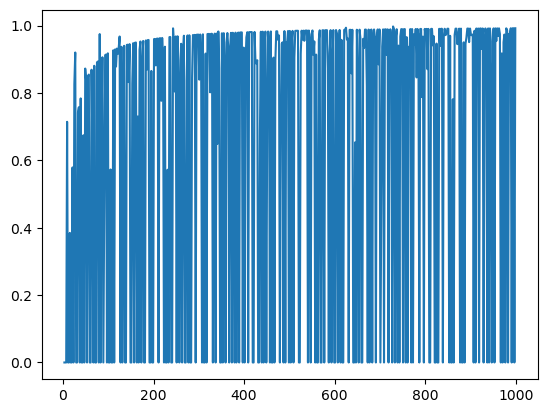

In [31]:

def faux_pos_Fermat(k) :

    return -1


def menteurs_Fermat(n) : 
    return -1


En fait il existe des nombres qui ne sont absolument pas detectés par le test de Fermat. Parmi eux les nombre de Carmichel (il en existe une infinité).

Observer le phénomène sur les exemples donnés.

In [ ]:
carmichael = [561, 1105, 1729, 2465, 2821, 6601]


---

## 5 Test de Miller–Rabin

### Théorie

(source : wikipedia)

Le test de Miller--Rabin se base sur la propriété suivante :

prenons $s$ le plus grand entier tel que $2^s | (n-1)$ et $d = \frac{n-1}{2^s} $. Alors

si
$$d\not\equiv1\pmod n\quad{\rm et}\quad\forall r\in\{0,1,\ldots,s-1\}\quad a^{2^rd}\not\equiv-1\pmod n$$
alors n est composé, et a est appelé un témoin de Miller pour le fait que n est composé. 
 -----------

L'algorithme suivant permet de déterminer si un entier $a$ est un témoin de Miller pour l'entier $n$

>Témoin_de_Miller(n, a):    
>
>> calculer $s$ et $d$ tels que $n-1 = 2^s d$
>>
>> $x = a^d \mod n$
>>
>> si x==1 ou x == n-1
>>>
>>>renvoyer faux
>>
>> répéter $s-1$ fois
>>> $x = x^2 \mod n$
>>>
>>> si x = n-1
>>>>
>>>>renvoyer faux
>renvoyer vrai





Ce test est très fiable, notamment par le théorème suivant :
>**Proposition**— Pour un nombre impair composé (ie non premier) $n$, au moins $\frac34$  des entiers $a$ tels que  $1 < a < n $, sont des témoins de Miller pour $n$. 
------------------
>__Question 6 :__ 
> Implémentez une fonction `test_MillerRabin(n)` qui applique ce critère pour un témoin, et une fonction `is_probable_prime_MillerRabin(n,k)` qui teste $k$ témoins.

In [6]:
def test_MillerRabin(n, a):

    return False

def is_probable_prime_MillerRabin((n, k=5):
    return True



SyntaxError: expected ':' (1905244590.py, line 5)

Le test de Miller--Rabin fonctionne si l'on teste tous les témoins, cependant il est moins efficace opur certain nombres, comme les nombres de Carmichel (mais cela fini par marcher avec un nombre assez grand de temoins)


>__Question 7 :__ 
> Donnez des exemples aléatoires de faux positifs (en fonction du nombre d'essais $k$), et écrire une fonction donnant le tableau et le nombre de menteurs de Miller--Rabin pour un entiers donné.
Tracer la proportion de menteurs en fonction de $n$

1.0 0.0010050251256281408


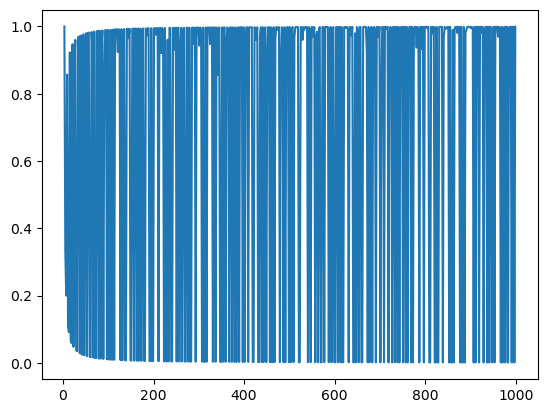

In [30]:
def menteurs_Miller_Rabin(n) : 
    ment = np.zeros(n-2,int)
    for a in range(n-2):
        ment[a] = miller_rabin_once(n,a)
    return ment, (n-2 -sum(ment)) ,(n-2 -sum(ment))/(n-2)

menteurs_Miller_Rabin(18)


prop = [menteurs_Miller_Rabin(i)[2] for i in range(3,1000,2)]

print(max(prop),min(prop))

plt.plot(np.arange(3,1000,2),prop)

##il y a un problème, on a des nombre avec une proportion de temoins <<3/4 ???

---

## Conclusion

On *sait* tirer relativement efficacement et avec une certitude acceptable des nombres premiers !

Cette approche est réellement utilisée en pratique : https://gmplib.org/manual/Number-Theoretic-Functions